In [ ]:
%load_ext autoreload
%autoreload 2

import argparse
import os
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
# import sys
# # sys.path.append('/home/chenjn/rna2adt')
# sys.path.append('./')

In [2]:
import numpy as np
from tqdm import tqdm
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import fowlkes_mallows_score as FMI
from sklearn.metrics import silhouette_score as SC
import dataset
import dataloaders
import scanpy as sc
import scbasset_ori as scbasset
import sklearn
from utils import get_R
from biock import make_directory, make_logger, get_run_info
from biock.pytorch import model_summary, set_seed
from biock import HG19_FASTA_H5, HG38_FASTA_H5

from torch.utils.tensorboard import SummaryWriter

from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from utils import find_res_label

No module named 'pyfaidx'


In [ ]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    assert y_pred.size == y_true.size
    
    encoder = LabelEncoder()
    encoder = encoder.fit(np.unique(y_true))
    y_true = encoder.transform(y_true).astype(np.int64)
    y_pred = y_pred.astype(np.int64)

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # ind = linear_assignment(w.max() - w)
    ind = linear_sum_assignment(w.max() - w)
    ind = np.array((ind[0], ind[1])).T

    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
def label_scores(embeddings, labels):
    nn_ = NearestNeighbors(n_neighbors=20)
    nn_.fit(embeddings)
    knns = nn_.kneighbors(embeddings, return_distance=False)

    res = 0
    for i in range(len(embeddings)):
        num = 0
        for j in range(len(knns[i])):
            if labels[i] == labels[knns[i][j]]:
                num += 1
        res += num / len(knns[i])

    return res / len(embeddings)

In [ ]:
def test_model(model, loader, device, epoch):
    model.eval()
    all_label = list()
    all_pred = list()

    for it, (seq, adt) in enumerate(tqdm(loader)):
        seq = seq.to(device)
        output = model(seq)[0].detach()
        output = torch.sigmoid(output).cpu().numpy().astype(np.float16)

        adt = adt.numpy().astype(np.float16)

        all_pred.append(output)
        all_label.append(adt)

    all_pred = np.concatenate(all_pred, axis=0)
    all_label = np.concatenate(all_label, axis=0)

    R = get_R(all_pred, all_label, dim=0)[0]
    R1 = get_R(all_pred, all_label, dim=1)[0]

    R = np.nanmean(R)
    R1 = np.nanmean(R1)

    embedding = model.get_embedding().detach().cpu().numpy().astype(np.float32)

    adata1 = sc.AnnData(
        embedding,
        obs=adtT.obs,
    )
    sc.pp.neighbors(adata1, use_rep='X')
    sc.tl.umap(adata1)

    sc.tl.louvain(adata1)
    adata1.obs['louvain_res'] = find_res_label(adata1, len(np.unique(adata1.obs[label_key])))

    ari = ARI(adata1.obs['louvain'], adata1.obs[label_key])
    nmi = NMI(adata1.obs['louvain'], adata1.obs[label_key])
    ca = cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain'].values.to_numpy())
    fmi = FMI(adata1.obs['louvain'], adata1.obs[label_key])
    sci = SC(adata1.X, adata1.obs['louvain'].values.reshape(-1, 1))
    lsi = label_scores(embedding, adata1.obs[label_key])

    ari_res = ARI(adata1.obs['louvain_res'], adata1.obs[label_key])
    nmi_res = NMI(adata1.obs['louvain_res'], adata1.obs[label_key])
    ca_res = cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain_res'].values.to_numpy())
    fmi_res = FMI(adata1.obs['louvain_res'], adata1.obs[label_key])
    sci_res = SC(adata1.X, adata1.obs['louvain_res'].values.reshape(-1, 1))

    if epoch is not None:
        print('ARI: ' + str(ari) + ', NMI: ' + str(nmi) + ', CA: ' + str(ca) + ', FMI', str(fmi) + ', SCI', str(sci) + ', LSI', str(lsi))
        print('ARI: ' + str(ari_res) + ', NMI: ' + str(nmi_res) + ', CA: ' + str(ca_res) + ', FMI', str(fmi_res) + ', SCI', str(sci_res))

        # writer.add_scalar('ARI', ari, global_step=epoch)
        # writer.add_scalar('NMI', nmi, global_step=epoch)
        # writer.add_scalar('CA', ca, global_step=epoch)
        # writer.add_scalar('FMI', fmi, global_step=epoch)
        # writer.add_scalar('SC', sci, global_step=epoch)
        # writer.add_scalar('PCC0', R, global_step=epoch)
        # writer.add_scalar('PCC1', R1, global_step=epoch)

    return R, R1, sci, sci_res, embedding

In [6]:
def split_dataset(length, tr, va):
    seq = np.random.permutation(np.arange(length))
    trs = seq[:int(length * tr)]
    vas = seq[int(length * tr) : int(length * (tr + va))]
    tes = seq[int(length * (tr + va)):]

    return trs, vas, tes

In [ ]:
seq_len = 1344
batch_size = 4
num_workers = 2
z_dim = 256 
lr = 0.01
max_epoch = 500
batch=None
seed = 3407

In [8]:
set_seed(seed, force_deterministic=True)

In [9]:
outdir = make_directory('./output')
# logger = make_logger(title="", filename=os.path.join(outdir, "train.log"))

In [ ]:
data = 'sln111'

In [11]:
if data in ['pbmc']:
    rna_data = './data/' + data + '/RNA.h5ad'
    adt_data = './data/' + data + '/ADT.h5ad'
    ref_data = './data/' + data + '/CCND.csv'
    label_key = 'celltype.l2'
elif 'reap' in data:
    adt_data = './data/' + data + '/ADT.h5ad'
    ref_data = './data/pbmc/CCND.csv'
    label_key = 'labels'
elif 'sln' in data:
    adt_data = './data/' + data + '/ADT.h5ad'
    ref_data = './data/pbmc/CCND.csv'
    label_key = 'cell_types'
elif data in ['ScoPE2']:
    adt_data = './baseline/scPROTEIN/data/SCoPE2_ADT.h5ad'
    ref_data = './data/pbmc/CCND.csv'
    label_key = 'CellType'
else:
    # logger.info('Not implemented!!!')
    print('Not implemented!!!')

In [ ]:
# import pandas as pd
# data = pd.read_csv(ref_data, index_col=0)
# data

In [13]:
adtT = dataset.SingleCellDataset(
    data=dataset.load_adata(adt_data, log1p=True, nor=True), 
    seq_ref=dataset.load_csv(ref_data),
    seq_len=seq_len, 
    batch=batch,
)

In [ ]:
adtT.obs[label_key]
len(adtT.obs)
len(adtT.var)

index
AAACCCAAGGGTAATT-1                  NKT
AAACCCAAGGTAAACT-1         CD122+ CD8 T
AAACCCACACTAGGTT-1       Transitional B
AAACCCACAGATACCT-1             Mature B
AAACCCACAGGAATAT-1                CD4 T
                            ...        
TTTGTTGGTAAGATCA-2             Mature B
TTTGTTGGTCAGACTT-2                CD4 T
TTTGTTGGTGTTTACG-2       Transitional B
TTTGTTGTCAGAATAG-2             Mature B
TTTGTTGTCGAGTGGA-2    Cycling B/T cells
Name: cell_types, Length: 16828, dtype: category
Categories (35, object): ['Activated CD4 T', 'B doublets', 'B-CD4 T cell doublets', 'B-CD8 T cell doublets', ..., 'Tregs', 'cDC1s', 'cDC2s', 'pDCs']

In [14]:
adata = sc.AnnData(
    adtT.X.T,
    obs=adtT.obs,
)
sc.pp.neighbors(adata, use_rep="X")
sc.tl.umap(adata)

In [15]:
sc.tl.louvain(adata, random_state=seed)

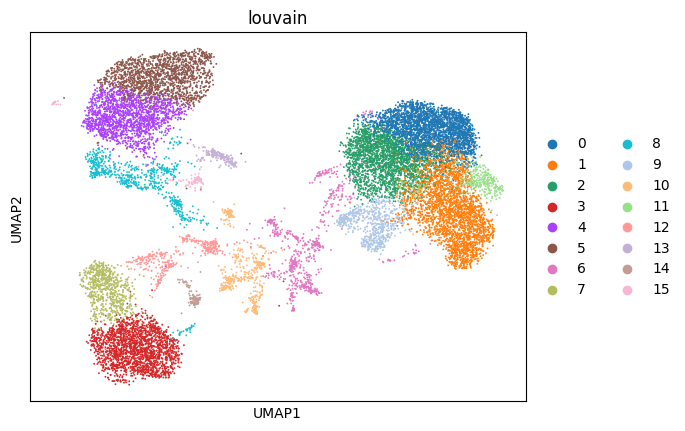

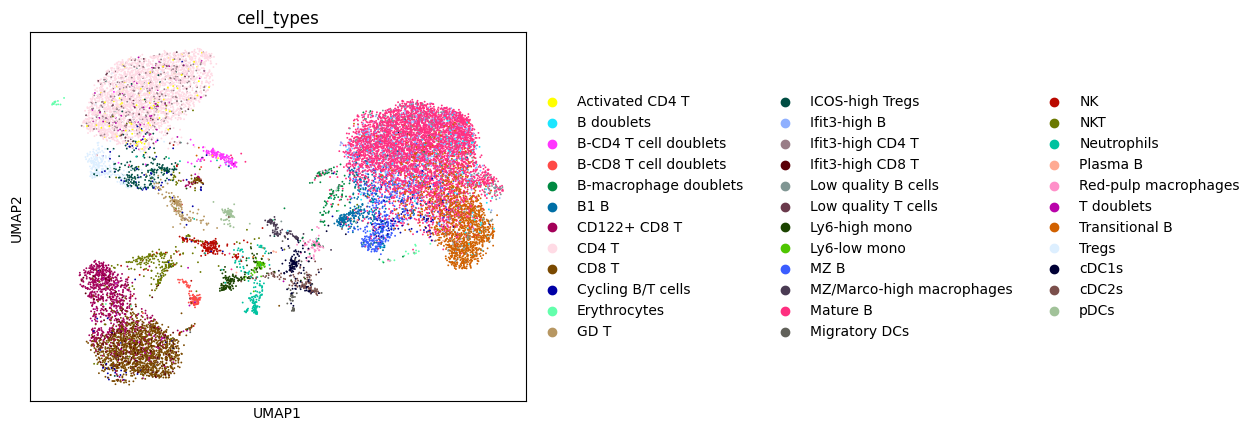

In [16]:
sc.pl.umap(adata, color='louvain')
sc.pl.umap(adata, color=label_key)

In [17]:
print(ARI(adata.obs['louvain'], adata.obs[label_key]))
print(NMI(adata.obs['louvain'], adata.obs[label_key]))
print(cluster_acc(adata.obs[label_key].to_numpy(), adata.obs['louvain'].values.to_numpy()))
print(FMI(adata.obs['louvain'], adata.obs[label_key]))
# print(SC(adata.X, adata.obs['louvain'].values.reshape(-1, 1)))

0.3980843844627284
0.6141567365356309
0.5033277870216306
0.47505481738710337


In [18]:
train_loader = DataLoader(
    adtT,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=4
)

In [19]:
sampled = np.random.permutation(np.arange(len(adtT)))[:10]
valid_loader = DataLoader(
    Subset(adtT, sampled),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

In [20]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
model = scbasset.scBasset(n_cells=adtT.X.shape[1], hidden_size=z_dim, seq_len=seq_len, batch_ids=adtT.batche_ids).to(device)
# logger.info("model parameters: {} {} {} {} ".format(str(seq_len), str(z_dim), str(lr * 1000), str(device)))
# writer = SummaryWriter('./log/'+ str(batch) + '_' + str(seq_len) + '_' + str(z_dim))

In [21]:
# print(model)

In [22]:
load = 0

# 100
if not load:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode="max",
        factor=0.95,
        patience=2,
        min_lr=1e-7
    )

    best_score = 0
    wait = 0
    patience = 15

    best_sci = 0
    best_embedding = None

    max_epoch = max_epoch
    for epoch in range(max_epoch):
        pool = [np.nan for _ in range(10)]
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}")
        model.train()
        for it, (seq, adt) in enumerate(pbar):
            seq, adt = seq.to(device), adt.to(device)
            # print(it,seq.shape,adt.shape);print()

            optimizer.zero_grad()
            with autocast():
                output = model(seq)[0]
                # print(output.shape, adt.shape)
                loss = criterion(output, adt)
                # print(loss)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            pool[it % 10] = loss.item()

            lr = optimizer.param_groups[-1]["lr"]
            pbar.set_postfix_str(f"loss/lr={np.nanmean(pool):.4f}/{lr:.3e}")
            # break
        
        
        if epoch % 10 == 0: 
            pcc0, pcc1, sci, sci_res, embedding = test_model(model, valid_loader, device, epoch)
            # pcc0, pcc1, sci, sci_res, embedding = test_model(model, train_loader, device, epoch)
            
            if sci > best_sci:
                best_sci = sci
                best_embedding = embedding

        #     logger.info("Validation{} PCC0={:.4f} PCC1={:.4f} SC={:.4f}".format((epoch + 1), pcc0, pcc1, sci))

            # val_score = sci

            # # scheduler.step(val_score)

            # if val_score > best_score:
            #     best_score = val_score
            #     wait = 0
            #     torch.save(model.state_dict(), "{}/best_scb_ori_{}_{}_{}_{}_{}_{}.pt".format(outdir, str(batch), str(seq_len), str(z_dim), str(lr * 1000), str(device), str(seed)))
            #     logger.info(f"Epoch {epoch+1}: best model saved\n")
            # else:
            #     wait += 1
            #     if wait <= patience / 2:
            #         embedding = model.get_embedding().detach().cpu().numpy().astype(np.float32)
            #         sc.AnnData(embedding, obs=adtT.obs).write_h5ad("{}/best_scb_ori_emb_{}_{}_{}_{}_{}_{}.h5ad".format(outdir, str(batch), str(seq_len), str(z_dim), str(lr * 1000), str(device), str(seed)))

            #         logger.info(f"Epoch {epoch+1}: early stopping patience {wait}/{patience}, embedding saved\n")
            #     else:
            #         logger.info(f"Epoch {epoch+1}: early stopping patience {wait}/{patience}\n")
            #     if wait >= patience:
            #         logger.info(f"Epoch {epoch+1}: early stopping")
            #         break

Epoch 1/500:   0%|                                                                                                                                                                                                                            | 0/20 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.96it/s]


ARI: 0.3165486828048267, NMI: 0.4527124891589113, CA: 0.4340979320180651, FMI 0.4388186160150035, SCI 0.03129797, LSI 0.4796886142144211
ARI: 0.11312351977786585, NMI: 0.353342811996824, CA: 0.18576182552888043, FMI 0.20237316190640472, SCI 0.0018627644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.13it/s]


ARI: 0.45836080791518496, NMI: 0.595965639791855, CA: 0.5568100784406941, FMI 0.5382998415612609, SCI 0.04178147, LSI 0.6136766104112203
ARI: 0.18150620314960936, NMI: 0.5094251992168392, CA: 0.2921321606845733, FMI 0.2819740694293327, SCI 0.015850093


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.30it/s]


ARI: 0.4670550848091804, NMI: 0.6030479158230556, CA: 0.559900166389351, FMI 0.5438676666815975, SCI 0.044443555, LSI 0.6328262419776558
ARI: 0.20112103666706668, NMI: 0.5310564722705474, CA: 0.33723555978131686, FMI 0.3012742999812709, SCI 0.02051315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.85it/s]


ARI: 0.5431357831494408, NMI: 0.626709691170894, CA: 0.6217613501307345, FMI 0.6162565913568532, SCI 0.08584063, LSI 0.6477002614689741
ARI: 0.2367674537380421, NMI: 0.5559411053703117, CA: 0.3922628951747088, FMI 0.3345607065834212, SCI 0.029892385


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.99it/s]


ARI: 0.5378849764587305, NMI: 0.637196135798275, CA: 0.6239600665557404, FMI 0.6084712751803665, SCI 0.09028806, LSI 0.6552323508438284
ARI: 0.22454812829190843, NMI: 0.5592602284171513, CA: 0.36213453767530307, FMI 0.3245905918958682, SCI 0.028340155


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.17it/s]


ARI: 0.5103195080710317, NMI: 0.633353501656672, CA: 0.6153434751604469, FMI 0.582388104072631, SCI 0.102997765, LSI 0.6612283099595886
ARI: 0.24680008531128822, NMI: 0.5672393078188167, CA: 0.3885785595436178, FMI 0.3447457366384472, SCI 0.04738237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.42it/s]


ARI: 0.5082003964882613, NMI: 0.6249711458846482, CA: 0.6045281673401474, FMI 0.5758391812614797, SCI 0.086597934, LSI 0.6670311385785537
ARI: 0.21980770437805694, NMI: 0.5607849963070808, CA: 0.3717019253624911, FMI 0.32039695090489373, SCI 0.03932049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.19it/s]


ARI: 0.4681045001258072, NMI: 0.6237661751540672, CA: 0.5754694556691229, FMI 0.5397704210836588, SCI 0.09146058, LSI 0.6685732113144731
ARI: 0.22559976758876518, NMI: 0.5618181979779018, CA: 0.3644521036367958, FMI 0.3255795513288034, SCI 0.046317313


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.70it/s]


ARI: 0.46089408749327737, NMI: 0.6208462738234927, CA: 0.559305918706917, FMI 0.5328886079184003, SCI 0.10368136, LSI 0.671253268362248
ARI: 0.2603637616658414, NMI: 0.5688133264132063, CA: 0.41430948419301167, FMI 0.3572825587482826, SCI 0.05766647


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.68it/s]


ARI: 0.4907667870186999, NMI: 0.6316091935080432, CA: 0.5935940099833611, FMI 0.5594570242844078, SCI 0.10593414, LSI 0.6726497504159695
ARI: 0.2520751777710264, NMI: 0.5720988961365616, CA: 0.4039695745186594, FMI 0.34933858137128143, SCI 0.0686183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.11it/s]


ARI: 0.42020328277185764, NMI: 0.6116122210597281, CA: 0.5155098645115284, FMI 0.49510692622237207, SCI 0.10926013, LSI 0.6743760399334406
ARI: 0.21384125587705563, NMI: 0.557222337206045, CA: 0.3623128119800333, FMI 0.31593420609141115, SCI 0.050644323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.61it/s]


ARI: 0.4616383101021556, NMI: 0.6212053446903071, CA: 0.5581768481102923, FMI 0.5341700096689607, SCI 0.12874533, LSI 0.6746642500594233
ARI: 0.2228233477791007, NMI: 0.5608531791231068, CA: 0.36053006893273115, FMI 0.32408624741154224, SCI 0.05472692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.93it/s]


ARI: 0.46953588158304166, NMI: 0.628330856253455, CA: 0.5787378179225101, FMI 0.5411909584166964, SCI 0.13159762, LSI 0.6750683384834759
ARI: 0.23676595307583, NMI: 0.5659871302238473, CA: 0.37556453529831235, FMI 0.3363569106427893, SCI 0.06283879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.02it/s]


ARI: 0.4291866038701361, NMI: 0.6179430700566734, CA: 0.5318516757784645, FMI 0.5032344525470734, SCI 0.113949716, LSI 0.6754694556691176
ARI: 0.22546854175083214, NMI: 0.563504921290841, CA: 0.3561326360827193, FMI 0.3258365055040617, SCI 0.063572146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.81it/s]


ARI: 0.3968308242680625, NMI: 0.6021187501523165, CA: 0.493819824102686, FMI 0.4736322155354854, SCI 0.11274873, LSI 0.6758141193249327
ARI: 0.22309205207250465, NMI: 0.5674563917868101, CA: 0.3580342286665082, FMI 0.3230984953892041, SCI 0.059407443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.57it/s]


ARI: 0.40592393635307467, NMI: 0.6090115109587646, CA: 0.49726646066080343, FMI 0.4818473742775961, SCI 0.10876135, LSI 0.6758765153315855
ARI: 0.23246859658361427, NMI: 0.565980421872374, CA: 0.37110767768005704, FMI 0.33123006267364324, SCI 0.06560708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.21it/s]


ARI: 0.4175856008998981, NMI: 0.6173059623290482, CA: 0.5084977418588067, FMI 0.4926193932220771, SCI 0.10856822, LSI 0.6739392678868519
ARI: 0.2215833908969939, NMI: 0.5581370910112691, CA: 0.3582719277394818, FMI 0.3228356753480267, SCI 0.060185954


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.98it/s]


ARI: 0.40954648732891263, NMI: 0.6183030792393049, CA: 0.5108153078202995, FMI 0.48559941556695463, SCI 0.100836635, LSI 0.6752644402186762
ARI: 0.24725143134800867, NMI: 0.5683030475340156, CA: 0.3790705966246732, FMI 0.34698206502917944, SCI 0.06707087


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.16it/s]


ARI: 0.4309070647199961, NMI: 0.6203213311970104, CA: 0.5247801283574994, FMI 0.504166124644811, SCI 0.13409774, LSI 0.674396838602327
ARI: 0.2756395012841668, NMI: 0.5773947248731357, CA: 0.4332065604944141, FMI 0.37082913774070875, SCI 0.087237276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.82it/s]


ARI: 0.41517284259342746, NMI: 0.6123911341727758, CA: 0.5302472070358926, FMI 0.49044391948840577, SCI 0.1033746, LSI 0.6750089137152323
ARI: 0.2464612438475699, NMI: 0.5670284694048741, CA: 0.3920846208699786, FMI 0.34460837782592546, SCI 0.086235434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.65it/s]


ARI: 0.4253214911312896, NMI: 0.6207706140937175, CA: 0.5420727359163299, FMI 0.4996561302604388, SCI 0.104947194, LSI 0.6754248870929376
ARI: 0.2131128283735247, NMI: 0.5609916261445869, CA: 0.3548252911813644, FMI 0.3148432475390711, SCI 0.06241074


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.64it/s]


ARI: 0.41292594418122347, NMI: 0.6134725286075532, CA: 0.5243047302115522, FMI 0.48866700874501656, SCI 0.10558022, LSI 0.675968623722363
ARI: 0.23501830521979766, NMI: 0.5657297431942109, CA: 0.3857261706679344, FMI 0.3350040334019599, SCI 0.06386037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


ARI: 0.4191962573446149, NMI: 0.6211304124653209, CA: 0.5105776087473259, FMI 0.4939870599451736, SCI 0.10755012, LSI 0.6755318516757749
ARI: 0.2356233296965912, NMI: 0.5655270979538592, CA: 0.37104825291181365, FMI 0.33603228998423795, SCI 0.06597686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.83it/s]


ARI: 0.44538430186976785, NMI: 0.6271014262778826, CA: 0.5497979557879724, FMI 0.5183729178857526, SCI 0.10871387, LSI 0.6752079866888453
ARI: 0.2589894622366398, NMI: 0.5746588621036082, CA: 0.4161516520085572, FMI 0.35576512095415874, SCI 0.06772839


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.20it/s]


ARI: 0.4169968769924265, NMI: 0.6049815033350138, CA: 0.5038626099358212, FMI 0.4922815567517437, SCI 0.10315036, LSI 0.6736510577608696
ARI: 0.2583613705121619, NMI: 0.5730013702272413, CA: 0.3963632041835037, FMI 0.35503478540656913, SCI 0.08365096


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.14it/s]


ARI: 0.41373273394278104, NMI: 0.6175329450866586, CA: 0.5038626099358212, FMI 0.4890802276141027, SCI 0.10642324, LSI 0.6750356548609405
ARI: 0.229593126257727, NMI: 0.5636642491503534, CA: 0.36694794390301877, FMI 0.32843405938850434, SCI 0.06420361


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


ARI: 0.4065782001621934, NMI: 0.6155203057591934, CA: 0.49780128357499404, FMI 0.48239351600869845, SCI 0.094305985, LSI 0.6746791062514842
ARI: 0.246004689187132, NMI: 0.5657310424108517, CA: 0.3888756833848348, FMI 0.3453830522382268, SCI 0.06736101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.94it/s]


ARI: 0.47390809830170727, NMI: 0.629373892869758, CA: 0.5857499405752318, FMI 0.5449880046812422, SCI 0.12477309, LSI 0.6748306394105026
ARI: 0.25701421910716143, NMI: 0.5740521506292419, CA: 0.39238174471119563, FMI 0.35362016557139464, SCI 0.08894493


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


ARI: 0.38617964805790606, NMI: 0.6051156378084425, CA: 0.49269075350606134, FMI 0.4642426876422813, SCI 0.100865684, LSI 0.6756625861659065
ARI: 0.24135003146214412, NMI: 0.5689731408214138, CA: 0.37556453529831235, FMI 0.34110113910444334, SCI 0.06723409


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Hard!!!!


ARI: 0.3778183208822386, NMI: 0.6011821305911051, CA: 0.4923936296648443, FMI 0.4565903880966726, SCI 0.102304906, LSI 0.6762716900404052
ARI: 0.2648537976420686, NMI: 0.5747974079776024, CA: 0.41276444021868314, FMI 0.3617835039605452, SCI 0.09364121


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]


ARI: 0.46073396783090087, NMI: 0.6333935485266375, CA: 0.5511647254575707, FMI 0.5333584283944404, SCI 0.113562904, LSI 0.6766520085571613
ARI: 0.25256585351540983, NMI: 0.5692770121560476, CA: 0.4136558117423342, FMI 0.34919829869164254, SCI 0.08477353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


ARI: 0.43525838496954783, NMI: 0.6161474425170752, CA: 0.5430235322082244, FMI 0.5087569631544263, SCI 0.1299912, LSI 0.6751337057285414
ARI: 0.26668635915306355, NMI: 0.5755313554537418, CA: 0.42369859757546946, FMI 0.3615431373009771, SCI 0.08319835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


ARI: 0.4487370932490632, NMI: 0.6203870988767081, CA: 0.5461730449251248, FMI 0.5206158246751349, SCI 0.10593956, LSI 0.6765925837889191
ARI: 0.21235978420635254, NMI: 0.5615196352999318, CA: 0.3580342286665082, FMI 0.31233863144449486, SCI 0.06189239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]


ARI: 0.3994142745368793, NMI: 0.6137387653679999, CA: 0.4988115046351319, FMI 0.4763224961778212, SCI 0.09312625, LSI 0.675175303066313
ARI: 0.22174161987647217, NMI: 0.5633939018480142, CA: 0.37639648205372, FMI 0.3212393009726484, SCI 0.05618799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


ARI: 0.4504428394354008, NMI: 0.6239870425996084, CA: 0.5474803898264797, FMI 0.5225086115623834, SCI 0.11376822, LSI 0.6753803185167524
ARI: 0.2485472365472383, NMI: 0.5718799616496848, CA: 0.38822201093415737, FMI 0.3462535919369412, SCI 0.07891283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


ARI: 0.36068169023863494, NMI: 0.6051379668835841, CA: 0.4700499168053245, FMI 0.4410570073444652, SCI 0.09058749, LSI 0.6754694556691202
ARI: 0.2355123396831667, NMI: 0.5663515340440781, CA: 0.39095555027335394, FMI 0.3347128330619625, SCI 0.059790205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]


ARI: 0.4653100349686052, NMI: 0.6320776498525593, CA: 0.5613857855954362, FMI 0.536663053110296, SCI 0.12727243, LSI 0.6748930354171594
ARI: 0.21438204884609302, NMI: 0.5570200933327432, CA: 0.3425837889232232, FMI 0.31622272886521063, SCI 0.05693499


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


ARI: 0.4510732752742991, NMI: 0.6338244720321675, CA: 0.5593653434751604, FMI 0.5241036634705568, SCI 0.11912838, LSI 0.6751039933444232
ARI: 0.24430755356097988, NMI: 0.5707773761727881, CA: 0.3939267886855241, FMI 0.3434533345491072, SCI 0.08520958


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


ARI: 0.4184057855863431, NMI: 0.6182038606637038, CA: 0.5277513667696696, FMI 0.49352840939618015, SCI 0.11021026, LSI 0.6754694556691194
ARI: 0.2238826428323414, NMI: 0.5605684016096061, CA: 0.37265272165438557, FMI 0.32452533674466705, SCI 0.062406868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


ARI: 0.39890860774366094, NMI: 0.6133227223106129, CA: 0.4942952222486332, FMI 0.4755216260103186, SCI 0.10331914, LSI 0.674295816496312
ARI: 0.2812801659286471, NMI: 0.5840843701194737, CA: 0.42970049916805325, FMI 0.37468197330234815, SCI 0.091051675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


ARI: 0.3994830676278626, NMI: 0.6127466511653009, CA: 0.5, FMI 0.47637059152441835, SCI 0.10385896, LSI 0.6738441882576635
ARI: 0.21759974042021413, NMI: 0.5602340668769321, CA: 0.3500713097218921, FMI 0.31807535607677784, SCI 0.06461464


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


ARI: 0.3536241123075993, NMI: 0.5927816453138873, CA: 0.46054195388637986, FMI 0.43467887014492057, SCI 0.08588893, LSI 0.6736005467078592
ARI: 0.2391538374414811, NMI: 0.5607616389025604, CA: 0.3874494889469931, FMI 0.3364731674416219, SCI 0.07967462


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


ARI: 0.42894630688447805, NMI: 0.6155903786298718, CA: 0.5380318516757785, FMI 0.5028090314448256, SCI 0.114465125, LSI 0.6743522700261431
ARI: 0.24539254053182716, NMI: 0.5668608479654089, CA: 0.3706917043023532, FMI 0.3437272864395867, SCI 0.071460284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


ARI: 0.3728617007805631, NMI: 0.5994350995420337, CA: 0.47789398621345375, FMI 0.4520487001543021, SCI 0.09633156, LSI 0.6738560732113176
ARI: 0.2505747159415906, NMI: 0.5711621448700941, CA: 0.38685524126455906, FMI 0.3493480622235976, SCI 0.06525898


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


ARI: 0.44509480929486156, NMI: 0.6258820940942309, CA: 0.5303660565723793, FMI 0.5172096230993092, SCI 0.12043667, LSI 0.6735351794627991
ARI: 0.24343694855942719, NMI: 0.5660018232688009, CA: 0.3752079866888519, FMI 0.3418378689342255, SCI 0.062065594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


ARI: 0.4511725199343716, NMI: 0.6251565272713656, CA: 0.5547896363204183, FMI 0.5253340654360428, SCI 0.123331375, LSI 0.672863679581646
ARI: 0.2458761466418112, NMI: 0.5647693038240034, CA: 0.3937485143807939, FMI 0.3444229479215654, SCI 0.064688906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


ARI: 0.3864309296361545, NMI: 0.6068035528974008, CA: 0.4693368195864036, FMI 0.4643551801493947, SCI 0.10167251, LSI 0.675115878298074
ARI: 0.2632603722042478, NMI: 0.5704341262622019, CA: 0.4212621820774899, FMI 0.35914030271458214, SCI 0.07951452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


ARI: 0.38479971869727164, NMI: 0.6034547827984794, CA: 0.48573805562158306, FMI 0.4629816770725396, SCI 0.09210478, LSI 0.6745780841454697
ARI: 0.2311529389288186, NMI: 0.5631176934970564, CA: 0.3639172807226052, FMI 0.33184306248622014, SCI 0.06436659


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


ARI: 0.4045970346778536, NMI: 0.6133318310088851, CA: 0.49762300927026387, FMI 0.4813044308244938, SCI 0.10341097, LSI 0.6752674114570932
ARI: 0.2445143785498511, NMI: 0.5720141622131241, CA: 0.3869740908010459, FMI 0.3422842922139553, SCI 0.087838665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


ARI: 0.41726989627861355, NMI: 0.6202621795056841, CA: 0.5414190634656525, FMI 0.49264516844045314, SCI 0.10702852, LSI 0.6752169004040856
ARI: 0.2596519497470497, NMI: 0.5742748864779339, CA: 0.432315188970763, FMI 0.3559153092066179, SCI 0.08864127


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.22it/s, loss/lr=0.3201/1.000e-02]


In [23]:
# model.load_state_dict(torch.load("{}/best_scb_ori_{}_{}_{}_{}_{}_{}.pt".format(outdir, str(batch), str(seq_len), str(z_dim), str(lr * 1000), str(device), str(seed))))
# # model.load_state_dict(torch.load("{}/best_scb_ori.pt".format(outdir)))
# embedding = model.get_embedding().detach().cpu().numpy().astype(np.float32)
embedding = best_embedding

adata1 = sc.AnnData(
    embedding,
    obs=adtT.obs,
)
# adata1 = sc.read_h5ad("{}/best_scb_ori_emb_{}_{}_{}_{}_{}_{}.h5ad".format(outdir, str(batch), str(seq_len), str(z_dim), str(lr * 1000), str(device), str(seed)))

sc.pp.neighbors(adata1, use_rep='X')
sc.tl.umap(adata1)

In [24]:
embedding.shape

(16828, 256)

In [25]:
# import pandas as pd
# pd.DataFrame(embedding, index=adtT.obs).to_csv('.//output/' + data + '/embeddings.csv')

In [26]:
sc.tl.louvain(adata1, random_state=seed)

adata1.obs['louvain_res'] = find_res_label(adata1, len(np.unique(adata1.obs[label_key])))

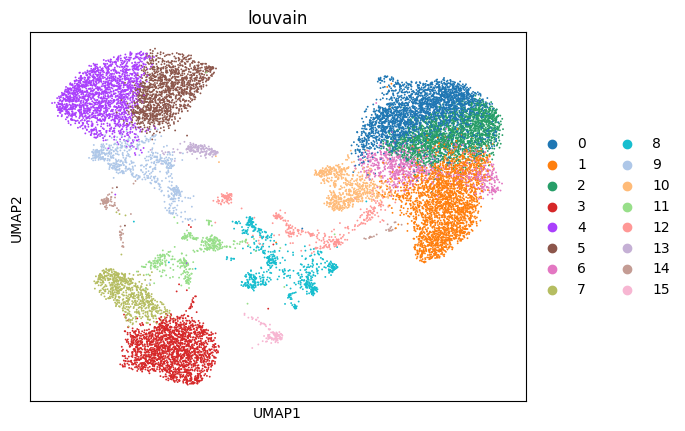

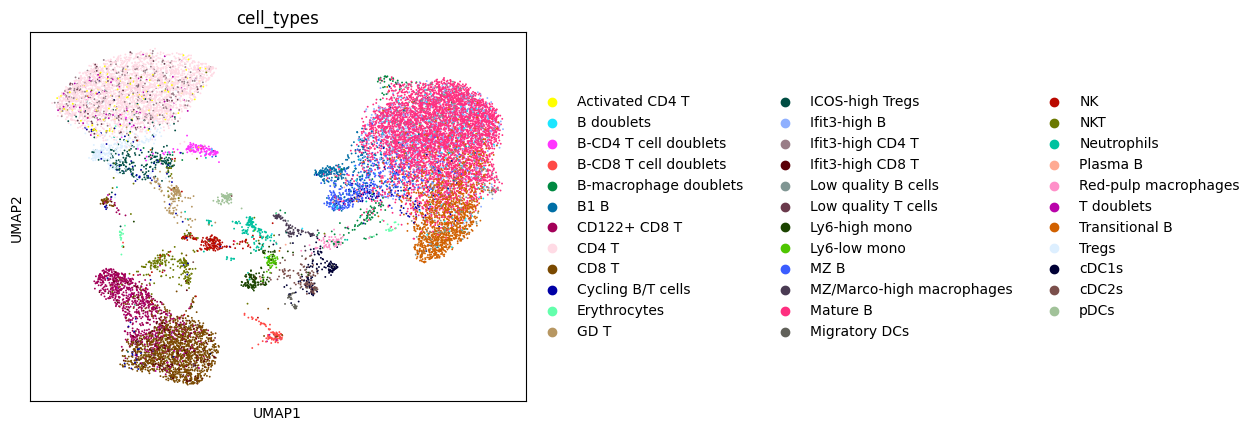

In [27]:
sc.pl.umap(adata1, color='louvain')
sc.pl.umap(adata1, color=label_key)

In [28]:
print(ARI(adata1.obs['louvain'], adata1.obs[label_key]))
print(NMI(adata1.obs['louvain'], adata1.obs[label_key]))
print(cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain'].values.to_numpy()))
print(FMI(adata1.obs['louvain'], adata1.obs[label_key]))
# print(SC(adata1.X, adata1.obs['louvain'].values.reshape(-1, 1)))

0.39766181235380926
0.613425117344602
0.4928096030425481
0.4744796443798963


In [29]:
print(ARI(adata1.obs['louvain_res'], adata1.obs[label_key]))
print(NMI(adata1.obs['louvain_res'], adata1.obs[label_key]))
print(cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain_res'].values.to_numpy()))
print(FMI(adata1.obs['louvain_res'], adata1.obs[label_key]))

0.2756395012841668
0.5773947248731357
0.4332065604944141
0.37082913774070875


In [30]:
pcc0, pcc1, sci, _, _ = test_model(model, valid_loader, device, epoch=None)
print("PCCs={:.4f}/{:.4f}".format(pcc0, pcc1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


PCCs=0.1614/-0.0740


In [31]:
pbar = tqdm(valid_loader, desc=f"Val Best")
model.eval()

outputs = []
for it, (seq, adt) in enumerate(pbar):
    seq = seq.to(device)
    output = model(seq)[0]

    outputs.append(output.detach().cpu().numpy())

outputs = np.concatenate(outputs, axis=0).T

adata2 = sc.AnnData(
    outputs,
    obs=adtT.obs,
)
sc.pp.neighbors(adata2, use_rep='X')
sc.tl.umap(adata2)

Val Best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]


In [32]:
sc.tl.louvain(adata2)

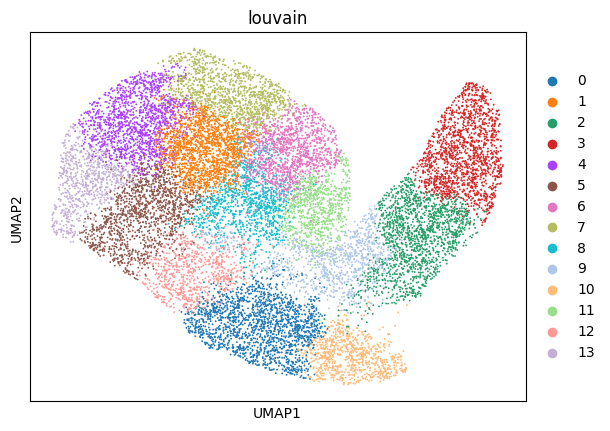

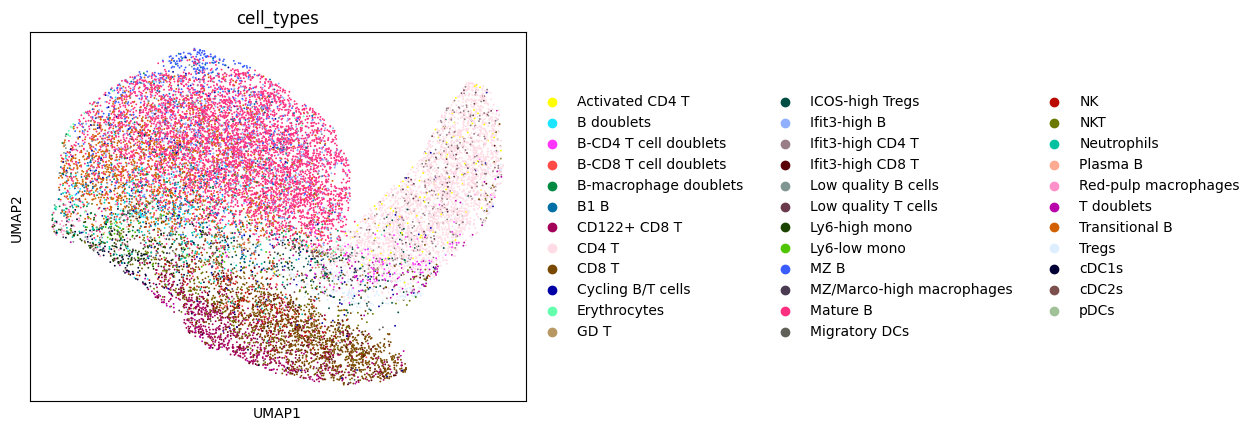

In [33]:
sc.pl.umap(adata2, color='louvain')
sc.pl.umap(adata2, color=label_key)

In [34]:
print(sklearn.metrics.adjusted_rand_score(adata2.obs['louvain'], adata2.obs[label_key]))
print(sklearn.metrics.normalized_mutual_info_score(adata2.obs['louvain'], adata2.obs[label_key]))

0.1994335502731904
0.3922051242094338
